# PINN Style Investigations

## Equation fully fixed. Only optimising the network. Loss includes PI

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append('../src')
from deepymod_torch.library_function import strain_input_library
from deepymod_torch.DeepMod import DeepMoD_known_eq
from deepymod_torch.VE_params import coeffs_from_model_params, model_params_from_coeffs

/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

No thresholding is done in thsi investigation. DeepMoD_PINN simply takes the diff_order to already arrive at teh correct equation (wrong coeffs) from the offset, and then trains around that. No attempt is made to remove terms, it is just a search to model the data with a NN, and find the rigth coeffs.

Hoepfully it finds the correct coeffs

if not, I guess we will test to see if

- starting again always reproduces teh same constants

- if teh system has converged or is still converging.

- whether launching the training with the already trained NN to give it more time allows us to correct for the error.

In [2]:
Input_Type = 'Strain'
Input_Function = lambda time_data: torch.sin(time_data)/time_data

In [3]:
data = np.loadtxt('../data/StressStrain/Strain Sinc E[1, 10, 1] V[20, 20].csv', delimiter=',')
time_Array, strain_array, Stress_Array = data[:3000,0:1], data[:3000,1:2], data[:3000,2:]

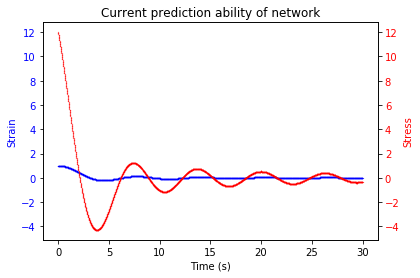

In [4]:
fig, ax1 = plt.subplots()
plt.title('Current prediction ability of network')
ax1.set_xlabel('Time (s)')
colour = 'blue'
ax1.set_ylabel('Strain', color=colour)
ax1.plot(time_Array, strain_array, color=colour, linestyle='None', marker='.', markersize=0.5)
ax1.tick_params(axis='y', labelcolor=colour)
ax2 = ax1.twinx()
colour = 'red'
ax2.set_ylabel('Stress', color=colour)
ax2.plot(time_Array, Stress_Array, color=colour, linestyle='None', marker='.', markersize=0.5)
ax2.tick_params(axis='y', labelcolor=colour)
ax1.set_ylim(ax2.get_ylim())
plt.show()

In [5]:
noise_level = 0.05
#noisy_stress_array = Stress_Array + noise_level * np.std(Stress_Array) * np.random.standard_normal(Stress_Array.shape)
noisy_stress_array = Stress_Array

In [6]:
number_of_samples = 1000

reordered_row_indices = np.random.permutation(time_Array.size)
reduced_time_array = time_Array[reordered_row_indices, :][:number_of_samples]
reduced_stress_array = noisy_stress_array[reordered_row_indices, :][:number_of_samples]

In [7]:
time_Tensor = torch.tensor(reduced_time_array, dtype=torch.float32, requires_grad=True)
Stress_Tensor = torch.tensor(reduced_stress_array, dtype=torch.float32)

no matter that lambda is unchanged, the function changes this itself to zero. This is already part of the default flow so i kept it in.

In [8]:
optim_config = {'lambda': 10**-5, 'max_iterations': 30001}

In [9]:
network_config = {'input_dim': 1, 'hidden_dim': 50, 'layers': 4, 'output_dim': 1}

In [10]:
lib_config = {'type': strain_input_library, 'diff_order': 3, 'coeff_sign': 'positive', 'input_type': Input_Type, 'input_expr': Input_Function}

prediction of what we are aiming for

In [11]:
not_floats = coeffs_from_model_params([1, 10, 1], [20, 20])
float_coeffs = [float(x) for x in not_floats]
float_coeffs

[0.045454545454545456,
 1.8181818181818181,
 0.09545454545454546,
 1.1818181818181819,
 1.8181818181818181]

This code block is important: It is here that I am fixing the coeffs. As I specified a `diff_order` of 3 above, I defined the equation, and then here I am defining the coeffs. Note of ofcourse I have put a coeff of 0 for the 3rd order derivatives. I want them to be calculated but they shouldn't appear in the equation.

In [12]:
coeffs = float_coeffs[:2] + [0] + float_coeffs[2:] + [0]
tuple_0 = [torch.tensor(coeffs).view(-1,1)]
tuple_1 = [torch.arange(len(coeffs))]
argcoeffs = (tuple_0, tuple_1)
argcoeffs

([tensor([[0.0455],
          [1.8182],
          [0.0000],
          [0.0955],
          [1.1818],
          [1.8182],
          [0.0000]])], [tensor([0, 1, 2, 3, 4, 5, 6])])

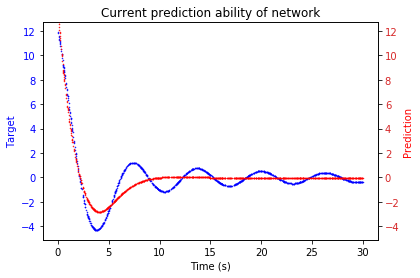

Epoch | Total loss | MSE | PI 
1200 7.6E-01 5.7E-01 1.9E-01
tensor([[0.0455],
        [1.8182],
        [0.0000],
        [0.0955],
        [1.1818],
        [1.8182],
        [0.0000]])
lrs are 0.001
Time elapsed: 19.0 minutes 40.78724789619446 seconds


In [ ]:
sparse_coeff_vector, sparsity_mask, network = DeepMoD_known_eq(time_Tensor, Stress_Tensor, network_config, lib_config, optim_config, argcoeffs)

In [ ]:
prediction = network(time_Tensor)
time_deriv_list, theta = library_function(time_Tensor, prediction, library_config)

In [ ]:
plt.plot(time_Array, theta[:, 4], label='zeroth', color='red', linestyle='None', marker='.', markersize=1)
plt.plot(time_Array, theta[:, 5], label='first', color='blue', linestyle='None', marker='.', markersize=1)
plt.plot(time_Array, theta[:, 6], label='second', color='green', linestyle='None', marker='.', markersize=1)
plt.plot(time_Array, theta[:, 7], label='third', color='black', linestyle='None', marker='.', markersize=1)
plt.legend()